<div style="max-width:66ch;">

# Lecture notes - Multilayered perceptron (MLP) for image classification

This is the lecture note for **MLP** and its use in image classification task.

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to MLP. I encourage you to read further about MLP. </p>

Read more:

- [Sparse categorical cross-entropy keras - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?version=nightly)
- [Probabilistic machine learning draft pp. 419-444 - Murphy (2022)](https://probml.github.io/pml-book/book1.html)
- [Classification metrics in Keras - machinelearningmastery](https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/)
- [Softmax function - wikipedia](https://en.wikipedia.org/wiki/Softmax_function)
- [How many hidden layers/neurons - Gad (2018) towardsdatascience](https://towardsdatascience.com/beginners-ask-how-many-hidden-layers-neurons-to-use-in-artificial-neural-networks-51466afa0d3e)
- [Rule of thumb - Ranjan (2019) towardsdatascience](https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af)

</div>


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data("mnist.npz")
X_train.shape, X_test.shape, y_train.shape, y_test.shape

2024-01-23 22:19:14.491928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

<div style="max-width:66ch;">

## Normalize data

Need to scale the data so that gradient descent don't get vanishing or exploding gradients. We choose min-max normalization to get values between 0 and 1.

$$X´ = \frac{X-X_{\min}}{X_{\max}-X_{\min}}$$

</div>

In [3]:
print(X_train.min(), X_train.max())
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

print(X_train.min(), X_train.max())

0 255
0.0 1.0


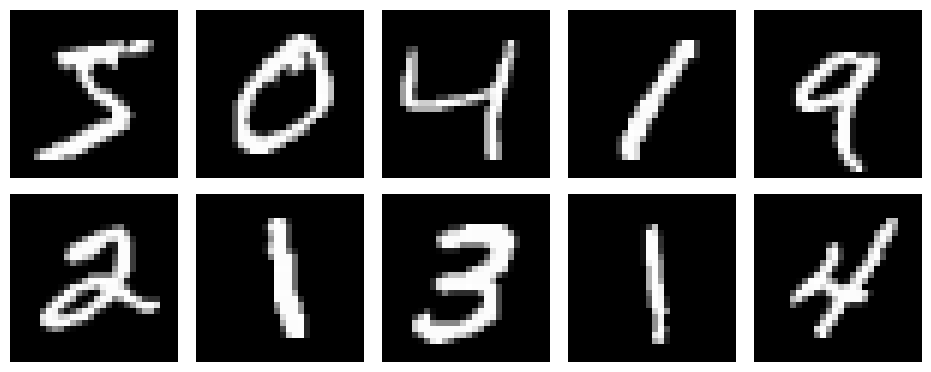

In [4]:
def display_images(data, nrows = 2, ncols = 5, figsize = (12,4)):
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i,:,:], cmap = "gray")
        ax.axis("off")

    fig.subplots_adjust(wspace=0, hspace=.1, bottom=0)

display_images(X_train)

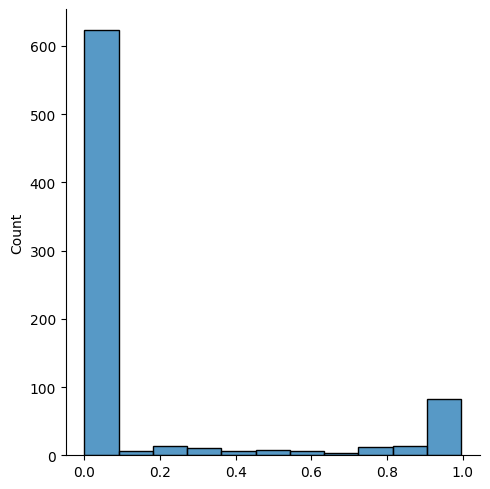

In [5]:
# a lot of darkness
sns.displot(data=X_train[5000, :, :].reshape(-1), kind="hist", legend=True)

<div style="max-width:66ch;">

## Create MLP model

Some key parameters to keep in mind
- 10 output nodes for 10 different classes
- softmax activation function in output layer for class probabilities
- sparse categorical cross-entropy loss function, when the number of classes in label ≥ 2
- categorical cross-entropy loss function, when number of classes in label ≥ 2 and it is one-hot encoded

### Dropout layer

Randomly shuts off nodes to decrease overfitting

</div>

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

def MLP_model(nodes=None, names=None, activations=[]):
    model = Sequential(name="MLP_model")
    # flattens the input
    model.add(Flatten(input_shape=(28, 28), name="Input_layer"))

    for node, name, activation in zip(nodes, names, activations):
        model.add(Dense(node, name=name, activation=activation))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])

    return model

# basically same as multimodal logistic regression, as the output uses softmax and we don't have any hidden layers
model_naive = MLP_model(nodes=[10], names=["Output_layer"], activations=["softmax"])
model_naive.summary()


Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 784)               0         
                                                                 
 Output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
model_naive.fit(X_train, y_train, validation_split=1/6, epochs=20, verbose=0)

In [8]:
naive_history = pd.DataFrame(model_naive.history.history)
naive_history.index = range(len(naive_history))
naive_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.498542,0.87032,0.307473,0.9147
1,0.315297,0.91166,0.280812,0.9206
2,0.292266,0.91786,0.268525,0.9268
3,0.280982,0.92154,0.261507,0.9283
4,0.273536,0.92332,0.259202,0.9305


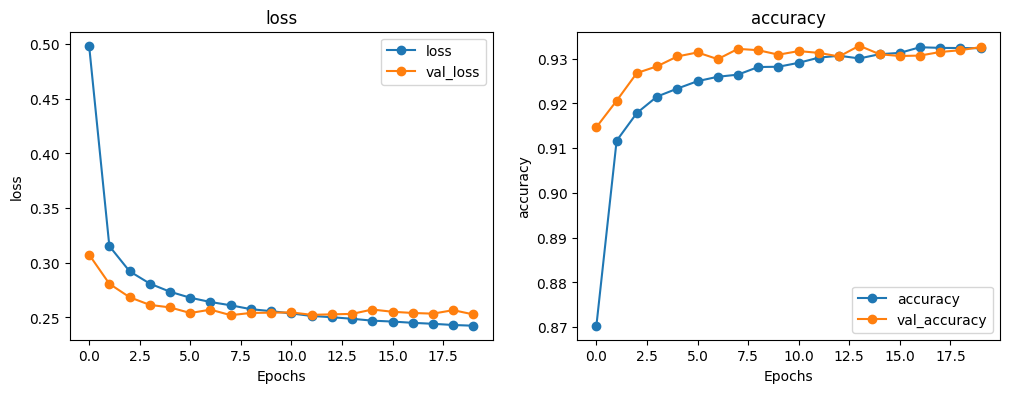

In [9]:
def plot_metrics(df_history, style="-o"):
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    metrics = [["loss", "val_loss"], ["accuracy", "val_accuracy"]]
    for ax, metric in zip(axes, metrics):
        df_history.plot(y=metric, xlabel="Epochs",
                        ylabel=metric[0],
                        title=metric[0], ax=ax, style=style)


plot_metrics(naive_history)
# don't let the scale on y-axis trick you, the curves are in fact very close to each other


<div style="max-width:66ch;">

## Add hidden layers 

- Murphy (2022) p. 425 uses 2 hidden layers with 128 nodes each

We take this network and see how it goes. 
  
</div>

In [10]:
model_deep = MLP_model(nodes=[128, 128, 10], activations=["relu", "relu",
          "softmax"], names=["Hidden_1", "Hidden_2", "Output"])

model_deep.summary()

Model: "MLP_model"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 784)               0         
                                                                 
 Hidden_1 (Dense)            (None, 128)               100480    
                                                                 
 Hidden_2 (Dense)            (None, 128)               16512     
                                                                 
 Output (Dense)              (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model_deep.fit(X_train, y_train, validation_split=1/6, verbose=0, epochs=20)

deep_history = pd.DataFrame(model_deep.history.history)
deep_history.index = range(len(deep_history))
deep_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.253449,0.92442,0.120686,0.9636
1,0.108029,0.96676,0.105847,0.9681
2,0.074191,0.97682,0.090024,0.9724
3,0.056314,0.98200,0.087335,0.9733
4,0.044178,0.98598,0.090729,0.9741


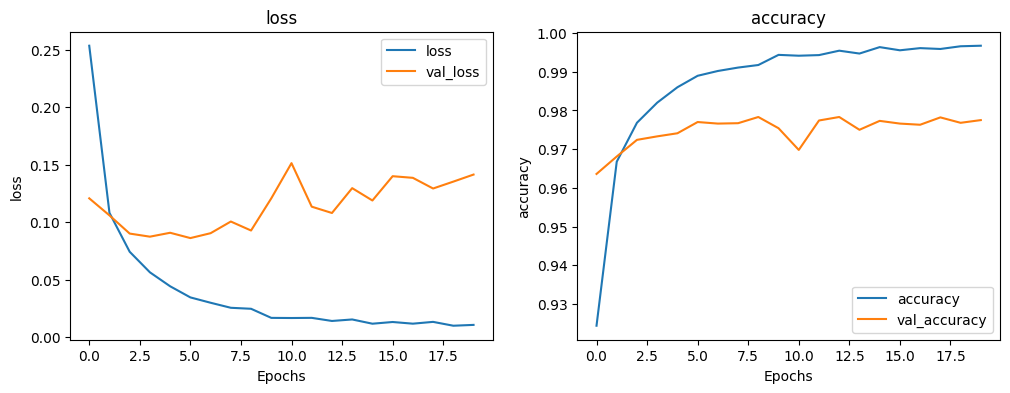

In [12]:
plot_metrics(deep_history, style = "-")
# we see validation loss increases and overfits 
# validation accuracy has stabilized, however in severe overfitting 
# the model fits to a lot of noise in training data could lead to significant
# drop in validation accuracy

<div style="max-width:66ch;">

### Pick the model
- we pick this model but chooses an early stopping and train for 6 epochs instead (before the loss starts increasing)
- note that now we train on all the training data, no splitting 
</div>

In [13]:
model_deep.fit(X_train, y_train, epochs = 6, verbose=0)

<div style="max-width:66ch;">

## Prediction and evaluation
</div>

313/313 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.96      0.99      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



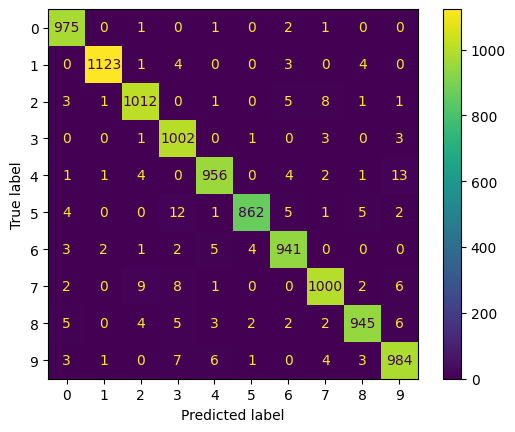

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model_deep.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## Display misclassifications

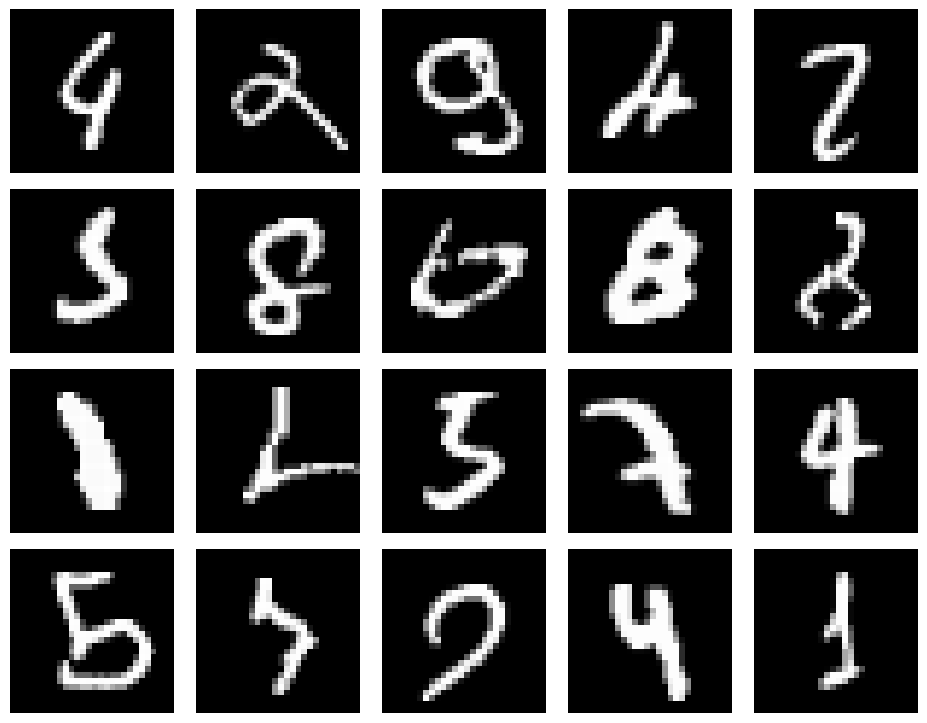

In [15]:
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_samples = X_test[misclassified_indices]

# a few misclassifications
display_images(misclassified_samples, 4,5, (12,8))

<div style="max-width:66ch;">

## Summary

In this lecture we've covered multilayered perceptron for image classification, showing first a naive approach which is same as multimodal logistic regression. Then we go into adding hidden layers, making it a deep MLP. Also we tried out a manual early stopping to decrease overfitting of the model

</div>

<div style="background-color: #FFF; color: #212121; border-radius: 1px; width:22ch; box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px; display: flex; justify-content: center; align-items: center;">
<div style="padding: 1.5em 0; width: 70%;">
    <h2 style="font-size: 1.2rem;">Kokchun Giang</h2>
    <a href="https://www.linkedin.com/in/kokchungiang/" target="_blank" style="display: flex; align-items: center; gap: .4em; color:#0A66C2;">
        <img src="https://content.linkedin.com/content/dam/me/business/en-us/amp/brand-site/v2/bg/LI-Bug.svg.original.svg" width="20"> 
        LinkedIn profile
    </a>
    <a href="https://github.com/kokchun/Portfolio-Kokchun-Giang" target="_blank" style="display: flex; align-items: center; gap: .4em; margin: 1em 0; color:#0A66C2;">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"> 
        Github portfolio
    </a>
    <span>AIgineer AB</span>
<div>
</div>
